# Predictions on different data quality

## Parameters and model

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationScale, DeviationSource
from metrics.utils import MetricLevel
from predictions.prediction import PredictionModel

time_series_start = 0
time_series_end = 180
column = SeriesColumn.CLOSE
stock = StockMarketSeries("Apple", "../data/apple.csv", time_series_start, time_series_end)

## Data - one price column

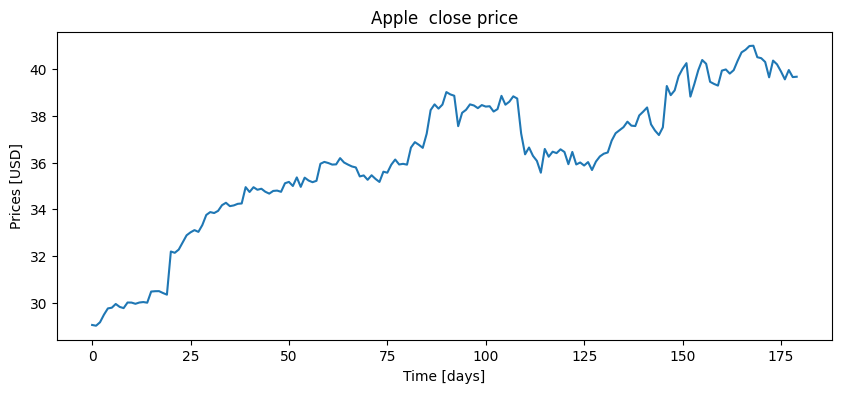

In [2]:
stock.plot_single_series(stock.real_series[column], column)

### Deviated data and its quality

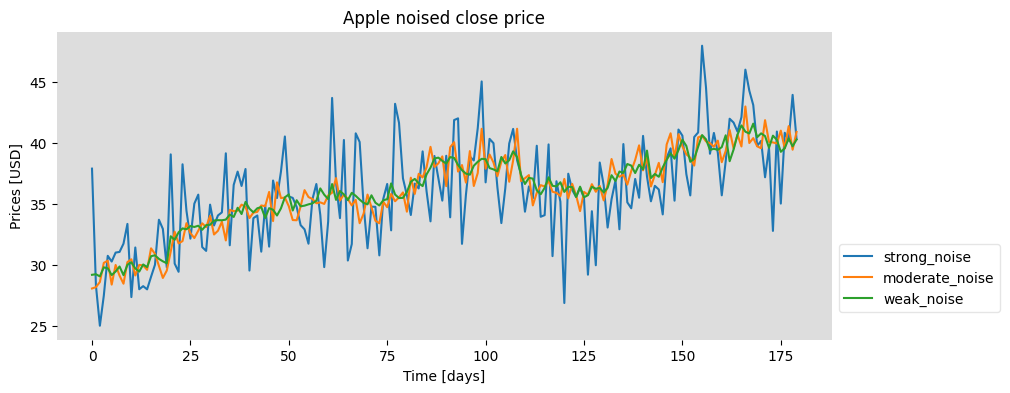

In [3]:
stock.plot_multiple_series("noised close price",
                           strong_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.HIGHLY][column],
                           moderate_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.MODERATELY][column],
                           weak_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][column])

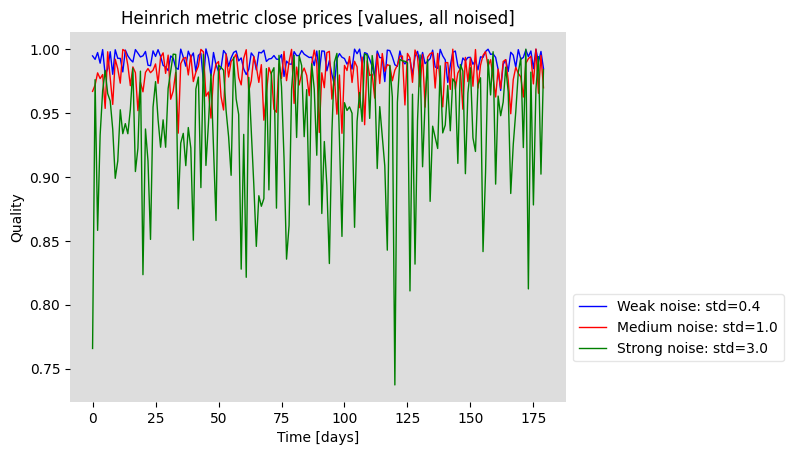

In [4]:
from metrics.correctness import HeinrichCorrectnessMetric

heinrich = HeinrichCorrectnessMetric(stock, alpha={column: 2.1})
qualities = heinrich.values_qualities(column, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=False, column_name=column)

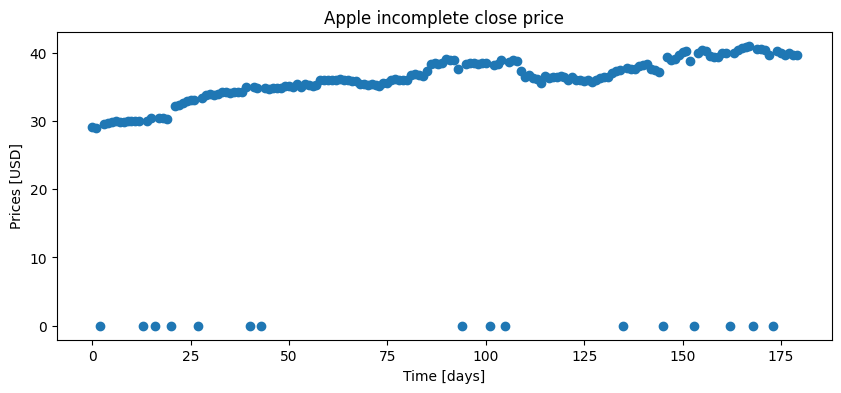

In [5]:
incomplete_data = stock.all_deviated_series[DeviationSource.INCOMPLETENESS][DeviationScale.MODERATELY][column]
stock.plot_single_series(incomplete_data, column, deviation="incomplete", plot_type="o")

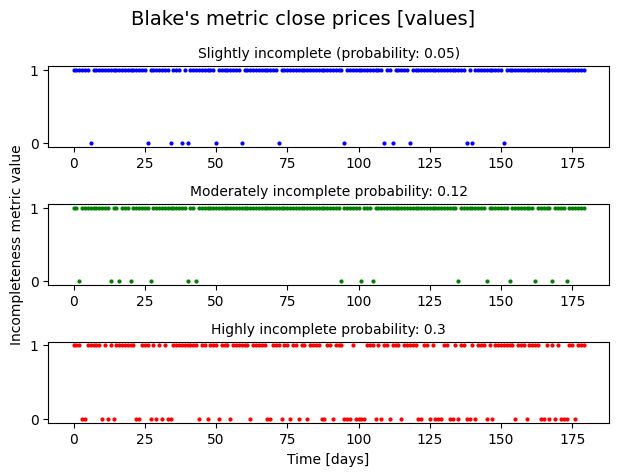

In [6]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities = blake.values_qualities(column)
blake.draw_blake(qualities, MetricLevel.VALUES, column_name=column)

## Predictions parameters

In [7]:
prediction_start = 150
iterations = 2

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [8]:
from arima import ManualArima

arima_type = ManualArima

## AR(5)

In [9]:
arima = model.configure_model(arima_type, p=5, q=0)

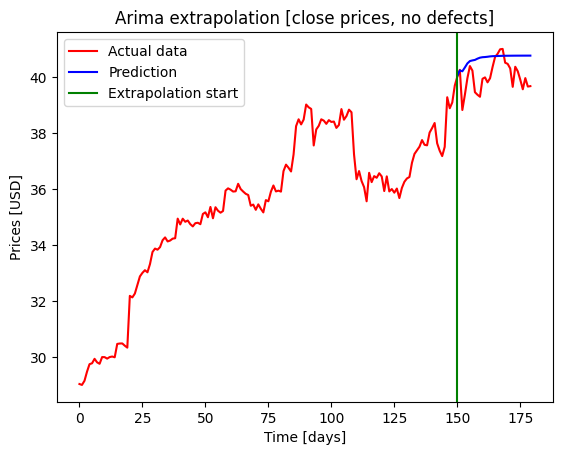

RMS: 0.783 


In [10]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [11]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 2 iterations]

   Defects source Defects scale Avg elapsed time [ms] Std dev elapsed time  \
0            none          none                  1208            46.669048   
1           noise      slightly                   918            67.882251   
2           noise    moderately                 952.5             9.192388   
3           noise        highly                1772.5            50.204581   
4  incompleteness      slightly                  1338            18.384776   
5  incompleteness    moderately                  2175           125.865007   
6  incompleteness        highly                  1463            25.455844   

  Avg RMS Std dev RMS  
0   0.783         0.0  
1   1.044         0.0  
2   1.062         0.0  
3   5.686         0.0  
4   9.885         0.0  
5  13.762         0.0  
6  19.272         0.0  


## ARIMA(5,1,5)

In [12]:
arima = model.configure_model(arima_type, p=5, q=2)

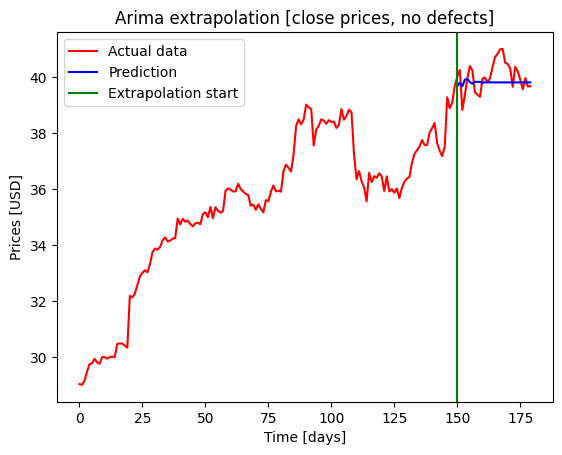

RMS: 0.56 


In [13]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [14]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 2 iterations]

   Defects source Defects scale Avg elapsed time [ms] Std dev elapsed time  \
0            none          none                  5118           100.409163   
1           noise      slightly                4130.5            26.162951   
2           noise    moderately                3768.5            101.11627   
3           noise        highly                  5732            89.095454   
4  incompleteness      slightly                  6503            12.727922   
5  incompleteness    moderately                  5735             5.656854   
6  incompleteness        highly                  5856            11.313708   

  Avg RMS Std dev RMS  
0    0.56         0.0  
1   0.759         0.0  
2   0.923         0.0  
3   4.987         0.0  
4   9.821         0.0  
5   13.71         0.0  
6  19.271         0.0  


## Reservoir computing

In [15]:
from predictions.ml import Reservoir

reservoir = model.configure_model(Reservoir)

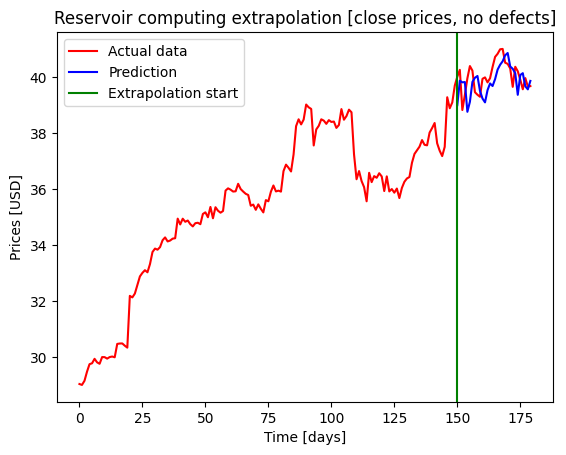

RMS: 0.745 


In [16]:
reservoir.present_prediction()

In [17]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 13).

## XGBoost

In [18]:
from ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

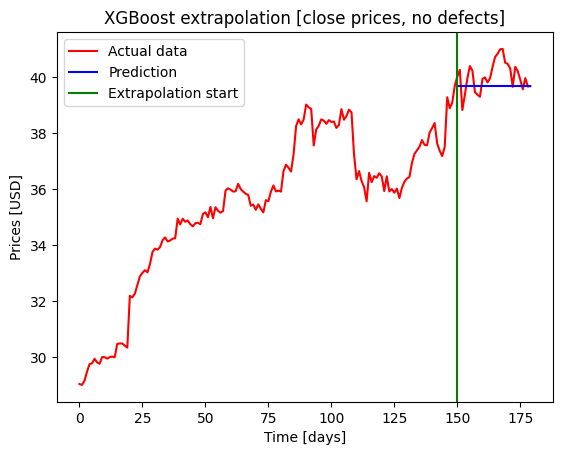

RMS: 0.616 


In [19]:
xgboost.present_prediction()

In [20]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Apple stock, close price, 2 iterations]

   Defects source Defects scale Avg elapsed time [ms] Std dev elapsed time  \
0            none          none                    56             9.899495   
1           noise      slightly                    55            14.142136   
2           noise    moderately                    54             4.242641   
3           noise        highly                    49             5.656854   
4  incompleteness      slightly                  47.5              2.12132   
5  incompleteness    moderately                    44                  0.0   
6  incompleteness        highly                  44.5             0.707107   

  Avg RMS Std dev RMS  
0   0.616         0.0  
1   0.999         0.0  
2   1.161         0.0  
3   3.278         0.0  
4   7.274         0.0  
5  14.507         0.0  
6  22.915         0.0  
